In [1]:
from DataPreprocessing import DatasetPreprocessor
from FileFinder import find_files
import logging
from tqdm import tqdm
from DataManager import DataManager
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from mplsoccer.pitch import Pitch

logging.basicConfig(level=logging.WARN)

# Find game files

In [2]:
files = find_files("../football_games")

# Get match animation

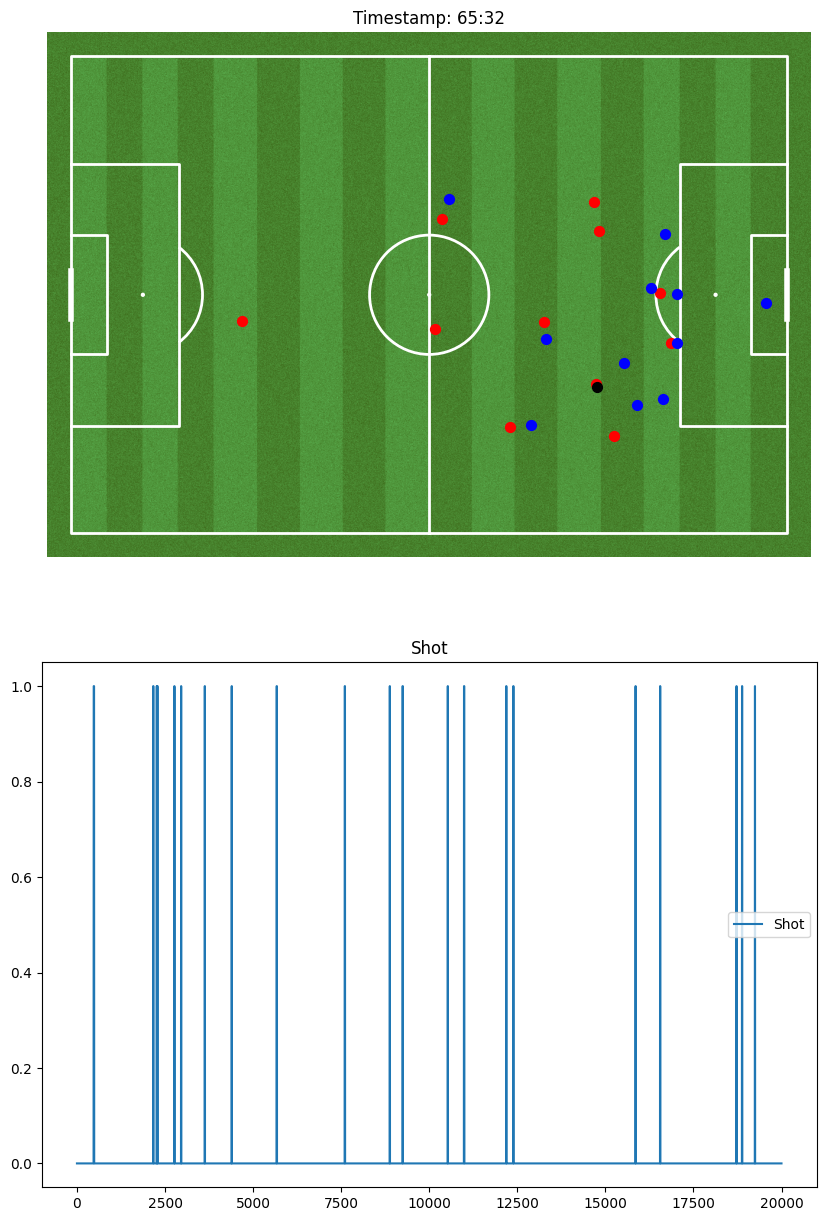

In [3]:
dataset = DatasetPreprocessor(1/5, files[0].name)
dataset.open_dataset(files[0].datafile, files[0].metafile, files[0].annotatedfile)
# not visible in jupyter notebook you can save
dataset.animate_game(frame_threshold=20_000, save_dir="animations/AnnotationTest.mp4", interval=30)

In [11]:
dataset.game_details
dataset.dataset.frames[0]

Frame(period=Period(id=1, start_timestamp=72062.72, end_timestamp=74831.0, attacking_direction=home-away), timestamp=0.0, ball_owning_team=Team(team_id='home', name='home', ground=home, players=[Player(player_id='home_2', team=..., jersey_no=2, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='home_15', team=..., jersey_no=15, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='home_1', team=..., jersey_no=1, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='home_9', team=..., jersey_no=9, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='home_19', team=..., jersey_no=19, name=None, first_name=None, last_name=None, starting=None, position=None, attributes={}), Player(player_id='home_22', team=..., jersey_no=22, name=None, first_name=None, last_name=None, start

# Missing players analysis

In [3]:
DM = DataManager(files)
player_violation = DM.player_violation()
print(f"There are {len(player_violation)} matches where there are no 22 players. These are: {player_violation}. Possible red cards!")

Total file count:   0%|          | 0/68 [00:00<?, ?it/s]

Total file count: 100%|██████████| 68/68 [06:54<00:00,  6.10s/it]

There are 5 matches where there are no 22 players. These are: ['NED-BEL', 'BEL-GRE', 'ICE-BEL', 'BEL-RUS', 'AUS-BEL']. Possible red cards!


All games were verified. it was noticed that for all games instead of NED-BEL and ICE-BEL the missing players were due to receiving red cards. Therefore NED-BEL and ICE-BEL need further investigation.

### NED-BEL

In [134]:
ned_bel = files[36]
dataset = DatasetPreprocessor(1/5, ned_bel.name)
dataset.open_dataset(ned_bel.datafile, ned_bel.metafile)
violated_timestamps = dataset._player_violation()
print([t/60 for t in violated_timestamps])
print("Players are missing only for 5 frames interpolation can be applied. There was a foul at that time!")

[20.379999999999807, 20.383333333333333, 20.386666666666617, 20.389999999999905, 20.39333333333319]
Players are missing only for 5 frames interpolation can be applied. There was a foul at that time!


In [113]:
player_violation_frame_indx = []
player_violation_timestamp = []
for index, frame in enumerate(dataset.dataset.frames):
    # check if all players are present in the current frame:
    if len(frame.players_coordinates.keys())<22:
        player_violation_frame_indx.append(index)
        player_violation_timestamp.append(frame.timestamp)
print(f"The first frame {np.min(player_violation_frame_indx)}, the last frame {np.max(player_violation_frame_indx)}")
print(f"The first timestamp {np.min(player_violation_timestamp)/60}, the last timestamp {np.max(player_violation_timestamp)/60}")

The first frame 6114, the last frame 6118
The first timestamp 20.379999999999807, the last timestamp 20.39333333333319


In [137]:
missing_players = set([player.player_id for indx, player in enumerate(dataset.dataset.frames[6114].players_coordinates)])
dataset.generate_encodings()
initial_players = dataset.player_encoder
substitutions = dataset.substitution_detection()
for pair in substitutions.values():
    for key in pair.keys():
        if key <= 6114:
            for pair2 in pair[key]:
                if len(pair2)!=0: 
                    initial_players[pair2[1]] = initial_players[pair2[0]]
                    initial_players.pop(pair2[0])
player = set(initial_players.keys()) - missing_players
print(f"The missing player is {player}!")

The missing player is {'away_3'}!


### ICE-BEL

In [102]:
ice_bel = files[42]
dataset = DatasetPreprocessor(1/5, ice_bel.name)
dataset.open_dataset(ice_bel.datafile, ice_bel.metafile)
violated_timestamps = dataset._player_violation()
print(f"Starts missing: {np.min(violated_timestamps)/60+45} and ends at {np.max(violated_timestamps)/60+45}")
print("Players are missing only for last five minutes.")

Starts missing: 90.92866666666669 and ends at 95.21200000000002


In [52]:
player_violation_frame_indx = []
player_violation_timestamp = []
for index, frame in enumerate(dataset.dataset.frames):
    # check if all players are present in the current frame:
    if len(frame.players_coordinates.keys())<22:
        player_violation_frame_indx.append(index)
        player_violation_timestamp.append(frame.timestamp)
print(f"The first frame {np.min(player_violation_frame_indx)}, the last frame {np.max(player_violation_frame_indx)}")
print(f"The first timestamp {np.min(player_violation_timestamp)/60+45}, the last timestamp {np.max(player_violation_timestamp)/60+45}")

The first frame 27321, the last frame 28606
The first timestamp 90.92866666666669, the last timestamp 95.21200000000002


In [108]:
missing_players = set([player.player_id for indx, player in enumerate(dataset.dataset.frames[27321].players_coordinates)])
dataset.generate_encodings()
initial_players = dataset.player_encoder
substitutions = dataset.substitution_detection()
for pair in substitutions.values():
    for pair2 in pair.values():
        if len(pair2)!=0:
            initial_players[pair2[0][1]] = initial_players[pair2[0][0]]
            initial_players.pop(pair2[0][0])
player = set(initial_players.keys()) - missing_players
print(f"The missing player is {player}!")

The missing player is {'home_8'}!


### BEL-GRE

In [149]:
bel_gre = files[37]
dataset = DatasetPreprocessor(1/5, bel_gre.home)
dataset.open_dataset(bel_gre.datafile, bel_gre.metafile)
violated_timestamps = dataset._player_violation()
print(f"Starts missing: {np.min(violated_timestamps)/60+45} and ends at {np.max(violated_timestamps)/60+45}")
print("Confirms that Greece player received the red card")

Starts missing: 65.44133333333326 and ends at 96.44133333333326
Confirms that Greece player received the red card


### BEL-RUS

In [151]:
bel_gre = files[58]
dataset = DatasetPreprocessor(1/5, bel_gre.name)
dataset.open_dataset(bel_gre.datafile, bel_gre.metafile)
violated_timestamps = dataset._player_violation()
print(f"Starts missing: {np.min(violated_timestamps)/60+45} and ends at {np.max(violated_timestamps)/60+45}")
print("Confirms that Russian player received the red card")

Starts missing: 89.34000000000015 and ends at 93.04333333333344
Confirms that Russian player received the red card


### AUS-BEL

In [153]:
aus_bel = files[61]
dataset = DatasetPreprocessor(1/5, aus_bel.name)
dataset.open_dataset(aus_bel.datafile, aus_bel.metafile)
violated_timestamps = dataset._player_violation()
print(f"Starts missing: {np.min(violated_timestamps)/60+45} and ends at {np.max(violated_timestamps)/60+45}")
print("Confirms that Belgian player received the red card")

Starts missing: 77.66533333333331 and ends at 96.40866666666673
Confirms that Belgian player received the red card


# Heatmaps

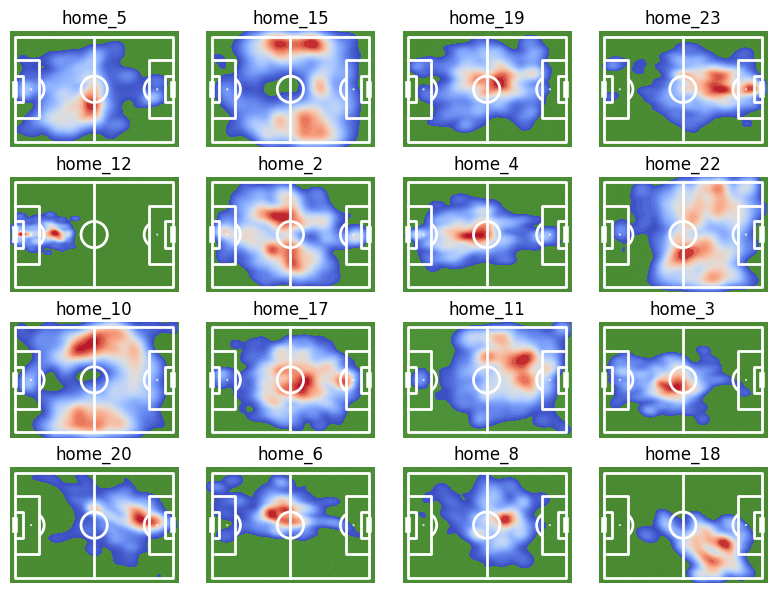

In [3]:
dataset = DatasetPreprocessor(1/5, files[0].name)
dataset.open_dataset(files[0].datafile, files[0].metafile)
dataset.generate_heatmaps()

# Get edges and animate them 

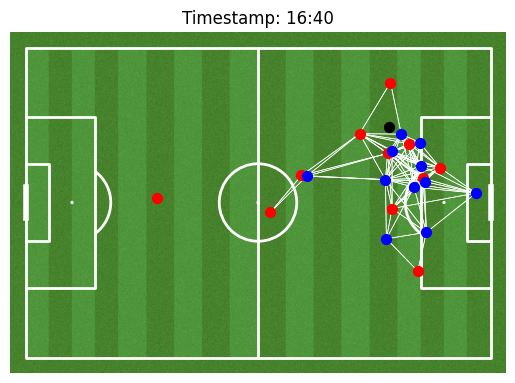

In [7]:
dataset = DatasetPreprocessor(1/5, files[0].name)
dataset.open_dataset(files[0].datafile, files[0].metafile)
dataset.animate_game(edge_threshold=0.2, frame_threshold=5000, save_dir="GameAnimationEdges.mp4", interval=10)

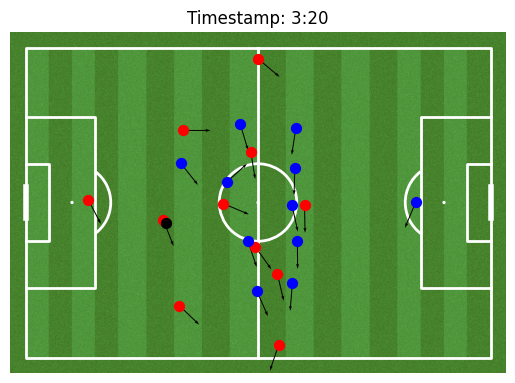

In [5]:
dataset = DatasetPreprocessor(1/5, files[0].name)
dataset.open_dataset(files[0].datafile, files[0].metafile)
dataset._generate_node_features()
dataset.animate_game(direction=True, frame_threshold=1000, save_dir="GameAnimationDirection.mp4", interval=100)

In [5]:
dataset = DatasetPreprocessor(1/5, files[0].name)
dataset.open_dataset(files[0].datafile, files[0].metafile)
dataset._generate_node_features()
dataset._generate_edges()
dataset._generate_annotaions()